<a href="https://colab.research.google.com/github/eshauchuk/Bandcamp_fan_counter/blob/main/%D0%94%D0%B5%D0%BC%D0%BE_%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D1%86%D0%B8%D1%8F_%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D1%8F_%D0%BA%D0%B0%D0%BA_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B0_%D0%BE%D0%BF%D1%82%D0%B8%D0%BC%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Генерация изображения как задача оптимизации

В этом уроке мы познакомимся с оптимизационным подходом к генерации изображений. А именно, предъявив функционал ошибки, мы с помощью алгоритма оптимизации будем минимизировать его изменяя нашу картинку. 

В этом уроке мы воспользуемся простейшей функцией -- среднеквадратичным отклонением одной картинки от другой (т.е. посчитаем попиксельную разницу). Такой функционал не решит задачу генерации текстур, но поможет на простом примере понять как можно генерировать изображения с помощью оптимизации.

In [1]:
%tensorflow_version 1.x
import tensorflow as tf

tf.enable_eager_execution()

TensorFlow 1.x selected.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import time

In [3]:
def clip_0_1(image):
    """
    Мы хотим уметь отображать нашу полученную картинку, а для этого ее значения должны 
    находится в промежутке от 0 до 1. Наш алгоритм оптимизации этого нигде не учитывает
    поэтому к полученному изображению мы будем применять "обрезку" по значению
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def load_img(path_to_img, max_dim=512):
    """
    Данная функция считывает изображение с диска и приводит его к такому размеру,
    чтобы бОльшая сторона была равна max_dim пикселей.

    Для считывания изображения воспользуемся функциями tensorflow.
    """
    img = tf.io.read_file(path_to_img) # считываени файла
    img = tf.image.decode_image(img, channels=3)  # декодинг
    img = tf.image.convert_image_dtype(img, tf.float32) # uint8 -> float32, 255 -> 1
    
    shape = img.numpy().shape[:-1]
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tuple((np.array(shape) * scale).astype(np.int32))

    img = tf.image.resize(img, new_shape) # изменение размера
    img = img[tf.newaxis, :] # добавляем batch dimension
    return img

def imshow(image, title=None):
    """
    Функция для отрисовки изображения
    """
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

Загрузим картинку на диск и отобразим ниже:

In [4]:
url = 'https://happywall-img-gallery.imgix.net/2657/grey_pebble_simplicity_display.jpg'
image_path = tf.keras.utils.get_file('stones.jpg', url)

(1.0, (1, 341, 512, 3))

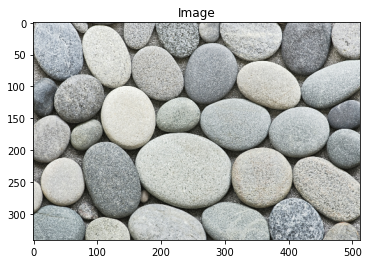

In [5]:
content_image = load_img(image_path)
imshow(content_image, 'Image')
content_image.numpy().max(), content_image.numpy().shape # убедимся, что картинка нужного размера, а также значения 
                                                         # лежат в промежутке от 0 до 1

Определим функцию потерь и оптимизатор

In [13]:
opt = tf.keras.optimizers.Adam(learning_rate=0.5)

def loss(image):
    return tf.keras.losses.MeanSquaredError()(content_image, image)

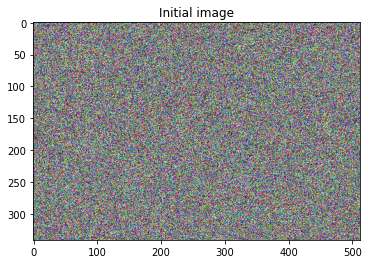

In [14]:
# image -- переменная, размером с исходную картинку, инициализированная случайно
image = tf.Variable(np.random.rand(*content_image.shape).astype(np.float32))
plt.figure()
imshow(image.numpy(), "Initial image")        

Теперь опишем шаг оптимизации, который должен каждый раз немного приближать нашу картинку к той, которая минимизирует функционал ошибки:

In [15]:
def train_step(image, loss_func):
    """
    Шаг оптимизации мы реализуем вручную (без .fit()). Такая реализация будет
    нам полезна в дальнейшем.

    """
    
    with tf.GradientTape() as tape: # "записываем" градиенты для дальнейшего использования
        loss = loss_func(image)
    grad = tape.gradient(loss, image) # dLoss/dImage
    opt.apply_gradients([(grad, image)]) # шаг градиентного спуск. в случае  GD: image = image - lambda*dLoss/dImage
                                         # картинка после этого шага изменилась!
    image.assign(clip_0_1(image)) # ~ image = clip_0_1(image), "обрезаем" неправильные значения
    return loss.numpy()

А теперь применим шаг train_step несколько раз к нашей картинке и посмотрим на промежуточные результаты:

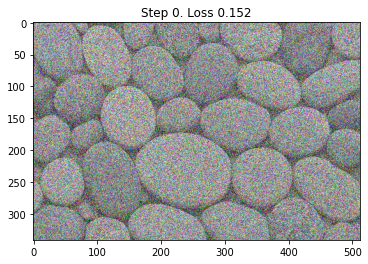

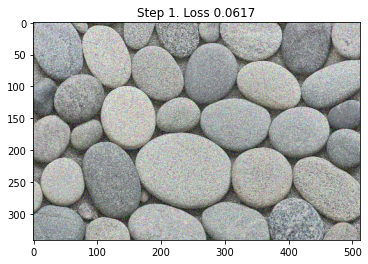

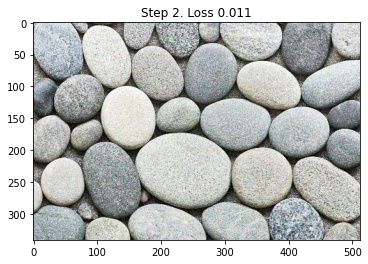

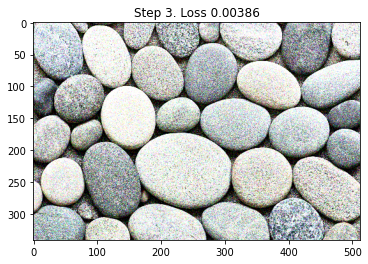

In [16]:
for i in range(4):
    loss_value = train_step(image, loss)
    plt.figure()
    imshow(image.read_value()[0], f"Step {i}. Loss {loss_value:.3}")

# Заключение 

Как мы и предполагали -- мы получили идентичную картинку. Хоть мы  пока и не решили задачу генерации текстур, но в этом уроке мы поняли механику того как вообще можно генерировать изображение с помощью оптимизации. 